# Regularization

When using multiple linear regression, there are several issues that can lead to instability in fitting the model. This means that small variations in the training dataset can result in significant changes in the best-fitting linear model. Let's explore a couple of potential problems:

1. **Irrelevant Independent Variables**: One source of instability occurs when some of the independent variables (denoted as x_i) used to predict the dependent variable (y) have no meaningful connection to it. In other words, they should not influence the value of the dependent variable at all. Including such irrelevant variables in the model can introduce noise and instability.

2. **Linear Correlation Between Variables**: Another issue arises when two independent variables, say, $x_1$ and $x_2$, are linearly correlated, meaning there is a linear relationship between them, such as $x_2 = a x_1 + b$. In this case, there is so-called multi-collinearity in the problem's variables and the fitting procedure becomes numerically unstable. 

In general, numerical instability means that a very small change in the training data can lead to very different values for the parameters in the model. In fact, when two variables have a perfect linear correlation your [model can return an infinite number of solutions for the parameters minimising the error](https://stats.stackexchange.com/questions/435986/what-exactly-is-model-instability-due-to-multicollinearity)! When the correlation is not perfect but only partial, this number if not infinite but can still be very large or, better said, completely different fitting parameters will be obtained given even tiny changes in the training data.

For exactly the same reason, adding "fake data" or artificially duplicating information by including linear functions of already existing independent variables can also lead to changes in the fitted model, even though no new useful information is introduced. This highlights the sensitivity of multiple linear regression to the data it is trained on, and the need for careful feature selection and preprocessing to improve model stability.

> From a visual/geometric point of view, this instability arises because there is an infinite number of planes that can contain the same line (or, to generalise, an infinite number of hyper-planes in $N$ dimensions that contain the an hyper-plane in $M < N$ dimensions). Try to think about why this is the case (you can find some help [here](https://www.nagwa.com/en/explainers/435186018068/))

[Regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics)) represents one potential solution to the aforementioned problems (although there is a somewhat animated debate around it, you can read more [here](https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Ridge_Regression.pdf)). 

In practice, the idea of regularisation is to change the definition of the cost function that the regression algorithm tries to minimise, in order to impose certain additional restriction to the form of the solution. The different regularisation techniques presented here use slightly different cost functions.

Whereas standard linear regression tries to minimise the sum of the squared error, different regularisation schemes add to this a second term, let us call it $L$. This term depends on the magnitude of the coefficients $\beta_1$ of the linear model and, importantly, increases monotonically with the magnitude of each of these coefficients (more later). 

To see why this can work in a somewhat empirical way, let us imagine that one of the independent variables included in our model has no relation with the dependent variable whose value we want to predict. Because of the term dependent on the values of the linear coefficients, the cost function will now try to give as little weight as possible to any of the variables and minimise the coefficients. In fact, it will try to give a value zero to all of them! This would not be possible without increasing the sum of the squared errors. However, for an independent variable that bears no relation to the dependent one, more or less any value of the coefficient should equally fit the data (except for the presence of noise). As a result, the coefficient for an unrelated variable found by a regularisation algorithm will be zero, or very close to this value. 

Similarly, when two of the independent variables are linearly correlated, removing one should provide (again, except for some noise in the data) an equally good fitting. Even in this case, the requirement to minimise a cost function that contains the linear coefficient means the algorithm will try to remove one of the variables from the model by giving it a value close to zero.

A different way to look at all of this (and much more accurate but somewhat heavy in math) starts by realising that standard linear regression can be thought of as a linear algebra problem whose solution can be found by matrix inversion. When one of the aforementioned problems occur, this inverse matrix is not well-defined, and its determinant will be close to zero, greatly magnifying numerical errors and the effects of noise. A thorough and very interesting discussion about this can be found [here](https://www.stat.purdue.edu/~boli/stat512/lectures/topic3.pdf)

## A simple example

Imagine we wanted to predict the weight of a random person from the population, about which we have the following data:

- age
- height
- shoe size
- favourite colour
- lucky number

It should be intuitive to recognise that not all of this data will be useful, for example the lucky number should not correlate to someone's weight, and this means that it is effectively adding noise to the data, making it more difficult to make an accurate fit. As discussed, regularisation is a regression technique used to eliminate the contributions of statistical irrelevant features. In particular, in this section, we will be looking into Ridge, Lasso and Elastic Net regression techniques. 

## Practicalities and sci-kit learn

> Whilst we will cover the basics of the theory behind these techniques, the implementations are all contained within `scikit-learn`

To begin, we will import the relevant modules, and in this case that involves importing `Ridge`, `Lasso` and `ElasticNet` from `sklearn.linear_model`. After this the data shall be imported and split into subsets, `X_train`, `y_train`, and `X_test`, `y_test`. This is done in the same way as the previous section but condensed into one cell. In short the following steps are taken:

1. Import the data using `pd.read_csv`
2. Split into input data (`X`) and output data (`y`) and export to a `numpy` array
3. Specify a training fraction and split the data into training and test sets


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import Ridge, Lasso, ElasticNet

# import the data and do the train test split
data = pd.read_csv('400-fish-preprocessed.csv')
data = data.sample(frac=1).reset_index(drop=True)

# separate input and output column names
columns = list(data.columns)
y_col = columns.pop(0)
print(f'Output Column Name: {y_col}\n')
print(f'Input Column Name List:\n{pd.Series(columns)}\n') # use pd.Series for readability

# split column in X, y which are the input and output variables respectively
y = data[y_col].to_numpy()
X = data[columns].to_numpy()

# show data
print(f'y:\n{y}\n')
print(f'X:\n{pd.DataFrame(X)}\n') # use DataFrame to improve readability

# Split the data into Training and Test Set
training_fraction = 0.1 # we will use 50% of the total data to train the model (this is arbitrarily chosen for now)
training_size = int(training_fraction * len(X))

X_train = X[:training_size]
X_test = X[training_size:]
y_train = y[:training_size]
y_test = y[training_size:]

print(f'Training Data:\n{pd.DataFrame(X_train)}\n\n{pd.Series(y_train)}\n')
print(f'Test Data:\n{pd.DataFrame(X_test)}\n\n{pd.DataFrame(y_test)}\n')

Output Column Name: Weight

Input Column Name List:
0       Length1
1       Length2
2       Length3
3        Height
4         Width
5         Bream
6          Pike
7         Smelt
8        Parkki
9         Perch
10    Whitefish
11        Roach
dtype: object

y:
[-0.70765855 -0.35288846 -0.7914625  -0.30260608 -0.70765855 -0.14896549
 -0.72162587 -0.27467143 -0.50373558 -0.60988726  1.68075427 -1.09315676
 -0.70765855 -1.08505571 -1.08477636 -0.66575657 -0.69369122 -1.09622957
 -1.02332012 -0.63782191  0.4711838  -1.07527858 -0.88923379  0.214185
  0.81478003 -0.35847539 -0.89482072  1.9601008  -0.69369122  0.14434837
  2.37912059 -0.76352785 -1.0939948   0.61923746  0.70304142  1.9601008
  0.28402163 -0.72162587 -0.27467143  3.49650671  0.80081271  0.32313014
 -0.41434469 -0.70765855  0.59130281 -0.02325955 -0.55401796 -1.0856144
  1.54108101  1.68075427  0.91255132 -0.56239835 -0.38641004  0.28402163
  1.68075427 -1.05712105  1.54108101 -1.08533505 -0.83336448  1.68075427
 -1.07863074

## Ridge Regression

The ordinary least squares (OLS) model, i.e., ordinary Multiple Linear Regression, tries to minimise this expression:

\begin{align}
\epsilon_{OLS} &= \sum_i (y_i - \hat{y}) ^ 2
\end{align}

where $\epsilon_{OLS}$ is the sum of the squares of the differences between the actual values $y$ and the predicted values $\hat{y}$.

In [Ridge regression](https://www.youtube.com/watch?v=Q81RR3yKn30), we are instead minimising a different expression:

\begin{align}
\epsilon_{R} &= \sum_i (y_i - \hat{y}) ^ 2 + \alpha \times \sum_{j=1}^N \beta_j^2 = \epsilon_{OLS} + \alpha L_1
\end{align}

where $\alpha$ is the **Ridge bias coefficient** also called the $L_1$ coefficient. $L_1 = \sum_{j=1}^N \beta_j^2 $ is the sum of the squares all of the (linear) regression coefficients. 

> From a geometric perspective, the $\beta s$ considered in $L1$ are the components of the multi-dimensional gradient of the hyper-plane representing your solution, or in other words the components of the vector perpendicolar to this hyperplane.

In looking at the expression above for the cost function $\epsilon_R$, you should see that it depends on the specific value of $\alpha$ chosen, which is a somewhat arbitrary input parameter in your model, although it will affect its accuracy and predictivity. Larger values of $\alpha$ will try to minimise the dependence on any of the independent variables, whereas for $\alpha=0$ we obviously recover the simple linear regression. 

In practice, estimating the right value of $\alpha$ can be done in different ways, but they are all related to maximising the model predictivity **on the test sample**, as we shall see later (not on the training data).

### Instructions

To use the `Ridge` class in sci-kit learn, we follow a similar scheme as the `LinearRegressor` class, which without all of the `print` functions, follows these steps:

| Step       | Code |
| :------------- |:-------------|
| Create a regressor (where `alpha` is the same as $\lambda _1$)   | `regressor = Ridge(alpha=alpha)` |
|  Fit to `X_train` and `y_train`   | `regressor.fit(X_train, y_train)`     | 
| Predict new `y` data (called `y_ridge` in this example) | `y_ridge = regressor.predict(X_test)`    |

> Note that in the example below, there are some embellishments added to loop over different `alpha` values, to print some of the resulting attributes, and to plot the results. However, in a production set of code, most of these things would not be present.

Score[0.25]: 0.7939397491960927
Intercepts[0.25]: -0.01241197131498567
Coefficients[0.25]:
0     0.125833
1     0.118470
2     0.111647
3     0.174714
4     0.294825
5     0.000000
6    -0.226228
7     0.304619
8    -0.223901
9    -0.248647
10    0.641181
11   -0.247024
dtype: float64

Score[0.5]: 0.8051975889223022
Intercepts[0.5]: -0.02088400736621948
Coefficients[0.5]:
0     0.130493
1     0.118909
2     0.119047
3     0.166991
4     0.288545
5     0.000000
6    -0.194521
7     0.286069
8    -0.177926
9    -0.232494
10    0.540296
11   -0.221423
dtype: float64

Score[0.75]: 0.8082229699943929
Intercepts[0.75]: -0.03098210799114981
Coefficients[0.75]:
0     0.133113
1     0.120860
2     0.123167
3     0.162327
4     0.275196
5     0.000000
6    -0.169048
7     0.259651
8    -0.148834
9    -0.218047
10    0.475172
11   -0.198893
dtype: float64



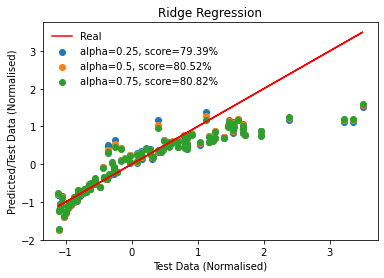

In [2]:
fig, ax = plt.subplots()
ax.plot(y_test, y_test, 'r-', label='Real')

for alpha in [0.25, 0.5, 0.75]:
    # Use the LinearRegression class as before 
    regressor = Ridge(alpha=alpha).fit(X_train, y_train)
    print(f'Score[{alpha}]: {regressor.score(X_test, y_test)}')
    print(f'Intercepts[{alpha}]: {regressor.intercept_}')
    print(f'Coefficients[{alpha}]:\n{pd.Series(regressor.coef_)}\n')

    # use LinearRegression.predict to create some predicted values
    y_ridge = regressor.predict(X_test)
    ax.scatter(y_test, y_ridge, label=f'alpha={alpha}, score={regressor.score(X_test, y_test) * 100 :.2f}%')


ax.set_xlabel('Test Data (Normalised)')
ax.set_ylabel('Predicted/Test Data (Normalised)')
ax.legend(frameon=False)
ax.set_title('Ridge Regression')
None

## Lasso Regression

In [Lasso regression](https://www.youtube.com/watch?v=NGf0voTMlcs), we are instead minimising a different expression:

\begin{align}
\epsilon_{L} &= \sum_i (y_i - \hat{y}) ^ 2 + \alpha \sum_{j=1}^N |\beta_j| = \epsilon_{OLS} + \alpha L_2,
\end{align}

where now $\alpha$ is the **lasso bias coefficient**, also known as the $L_2$ coefficient, where $L_2= \sum_j |b_j|$ is the sum of the absolute values of the regression coefficients. Note that Lasso and Ridge regression are similar but, as this [video](https://www.youtube.com/watch?v=NGf0voTMlcs) and this [post](https://stats.stackexchange.com/questions/176599/why-will-ridge-regression-not-shrink-some-coefficients-to-zero-like-lasso) explains, there are important, practical differences between the two that should be taken into account!

> We used the names $L_1$ and $L_2$ because these are those typically used in the statistics community for these particular quantities, but you might find different nomenclatures when reading external material. If you properly understand these algorithms, you should not find it difficult to connect different names for the same quantities!

### Instructions


| Step       | Code |
| :------------- |:-------------|
| Create a regressor (where `alpha` is the same as $\lambda _2$)   | `regressor = Lasso(alpha=alpha)` |
|  Fit to `X_train` and `y_train`   | `regressor.fit(X_train, y_train)`     | 
| Predict new `y` data (called `y_lasso` in this example) | `y_lasso = regressor.predict(X_test)`    |

Score[0.01]: 0.4640097660948749
Intercepts[0.01]: -0.33038675266108825
Coefficients[0.01]:
0     0.251453
1     0.000000
2     0.000000
3     0.000000
4     0.218757
5     0.000000
6    -0.000000
7     0.000000
8    -0.000000
9    -0.085316
10    1.309636
11   -0.000000
dtype: float64

Score[0.02]: 0.5000777196672859
Intercepts[0.02]: -0.31748494228305024
Coefficients[0.02]:
0     0.249158
1     0.000000
2     0.000000
3     0.000000
4     0.234901
5     0.000000
6    -0.000000
7     0.000000
8    -0.000000
9    -0.068781
10    1.129088
11   -0.000000
dtype: float64

Score[0.03]: 0.533003112687643
Intercepts[0.03]: -0.304494163099873
Coefficients[0.03]:
0     0.246133
1     0.000000
2     0.000000
3     0.000000
4     0.251673
5     0.000000
6    -0.000000
7     0.000000
8    -0.000000
9    -0.052388
10    0.948476
11   -0.000000
dtype: float64



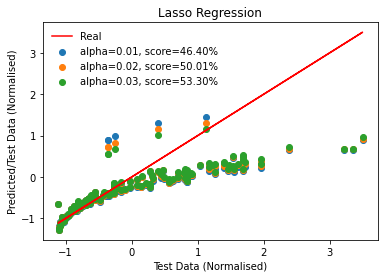

In [3]:
fig, ax = plt.subplots()
ax.plot(y_test, y_test, 'r-', label='Real')

for alpha in [0.01, 0.02, 0.03]:
    # Use the LinearRegression class as before 
    regressor = Lasso(alpha=alpha, max_iter=10000).fit(X_train, y_train)
    print(f'Score[{alpha}]: {regressor.score(X_test, y_test)}')
    print(f'Intercepts[{alpha}]: {regressor.intercept_}')
    print(f'Coefficients[{alpha}]:\n{pd.Series(regressor.coef_)}\n')

    # use LinearRegression.predict to create some predicted values
    y_lasso = regressor.predict(X_test)
    ax.scatter(y_test, y_lasso, label=f'alpha={alpha}, score={regressor.score(X_test, y_test) * 100 :.2f}%')


ax.set_xlabel('Test Data (Normalised)')
ax.set_ylabel('Predicted/Test Data (Normalised)')
ax.legend(frameon=False)
ax.set_title('Lasso Regression')
None


## ElasticNet Regression

In Elastic Net regression, we are instead minimising a different expression, which is effectively the combination of the previous ones together, all of which can be seen as a particular case of ElasticNet:

\begin{align}
\epsilon_{EN} &= \sum_i (y_i - \hat{y}) ^ 2 + \alpha_1 \times \sum_{j=1}^{N} b_j^2 + \alpha_2 \times \sum_{j=1}^N |b_j| = \epsilon_{OLS} + \alpha_1 L_1 + + \alpha_2 L_2
\end{align}

### Instructions


| Step       | Code |
| :------------- |:-------------|
| Create a regressor (where `alpha` is the same as $\lambda _2$)   | `regressor = ElasticNet(alpha=alpha, l1_ratio)` |
|  Fit to `X_train` and `y_train`   | `regressor.fit(X_train, y_train)`     | 
| Predict new `y` data (called `y_elastic_net` in this example) | `y_elastic_net = regressor.predict(X_test)`    |

In the next example, we are going to show a potential way to optimise the values of $\alpha_1$ and $\alpha_2$ for ElasticNet. In practice, one can perform a parameter scan to check for the combination of values that provide the highest score, as will be clarified in much more detail in the next section on **metrics**.

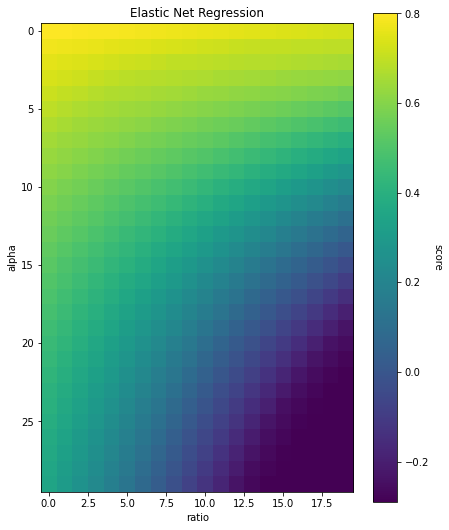

In [4]:
fig, ax = plt.subplots(figsize=(7,9))

result = np.zeros((30, 20))

for i, alpha in enumerate(np.arange(0.1, 3.1, 0.1)):
    for j, ratio in enumerate(np.arange(0.01, 0.21, 0.01)):
        # Use the LinearRegression class as before 
        regressor = ElasticNet(alpha=alpha, max_iter=100000, l1_ratio=ratio).fit(X_train, y_train)
        
        # use LinearRegression.predict to create some predicted values
        y_elastic_net = regressor.predict(X_test)
        result[i][j] = regressor.score(X_test, y_test)

im = ax.imshow(result)
ax.set_xlabel('ratio')
ax.set_ylabel('alpha')
ax.set_title('Elastic Net Regression')

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('score', rotation=-90, va="bottom")
#print(pd.DataFrame(result))
None

## (Extra) Food for thoughts

The choice of a particular regularization scheme in machine learning depends on the specific characteristics of the data and the underlying process you want to model. There is no one-size-fits-all answer, and the decision should be made on a case-by-case basis. Unfortunately, in practice, this preliminary step is often overlooked, especially by non-experts in machine learning. Instead, people often resort to conducting a parametric study where they attempt to minimize the error on the predicted values in the test sample.

In essence, the choice of regularization technique should be guided by a deeper understanding of the problem you are trying to solve. Here are some considerations to keep in mind:

1. **Data Characteristics**: Consider the nature of your data, such as its dimensionality, noise levels, and the presence of multicollinearity (correlation between independent variables). Some regularization methods may work better for specific data characteristics.

2. **Model Complexity**: Assess the complexity of the model you intend to use. If your model has a large number of parameters, you might need stronger regularization to prevent overfitting. On the other hand, if the model is relatively simple, milder regularization might suffice.

3. **Domain Knowledge**: Your understanding of the domain and the underlying process can guide the choice of regularization. Some techniques may align better with the known characteristics of the problem.

4. **Empirical Testing**: While an understanding of the problem is crucial, empirical testing is also valuable. Experiment with different regularization methods and hyperparameters on your data to see which one results in the best model performance, using techniques like cross-validation.

5. **Trade-offs**: Different regularization techniques come with trade-offs. Some may introduce bias in exchange for lower variance, while others may be more flexible but prone to overfitting. Consider what trade-offs you are willing to make in your specific application.

In summary, choosing the best regularization scheme is not a one-size-fits-all decision. It requires a thoughtful analysis of your data, problem domain, and the characteristics of the model. Empirical testing and careful consideration of trade-offs are often necessary to determine the most suitable regularization method for a given machine learning task.

You might wonder if there is a formal procedure that can be used in all cases. In fact, there is, although it is not necessarily simple to apply and often skipped for simplicity. The correct way is to apply a Bayesian approach, also called [Maximum-Entropy / Max-Likelihood estimation](https://en.wikipedia.org/wiki/Principle_of_maximum_entropy). This is far from the scope of these lectures but those of you who are interested in the fundamentals of Machine Learning (i.e., the math behind it), should be looking at Bayesian statistics, [Bayesian inference](https://en.wikipedia.org/wiki/Bayesian_inference#:~:text=Bayesian%20inference%20is%20a%20method,and%20especially%20in%20mathematical%20statistics.). 

If you want to have ideas for a long summer reading that can change your entire perspective about Science and how any set of data should be interpreted, truly understand what "Learning" means and demistify Artificial Intelligence, I suggest you try to read the masterpiece ["Probability Theory: The Logic of Science"](https://bayes.wustl.edu/etj/prob/book.pdf) by Jaynes, one of the founding fathers of modern statistics (it will take you a few years but it is enlightening!)

Just to give you an idea of how this choice can be made, you should consider the fact that
the **selection of a specific cost function**, associated with each regularization method, **reflects your expectations about how the system should behave**. In essence, different cost functions enable you to incorporate your knowledge or assumptions about the system into your modeling process.

Here are a couple of examples to illustrate this concept:

1. **Ridge Regression**: If you expect that, on average, the N variables in your dataset should not strongly influence your model (meaning their average impact on the model should be close to zero), and the coefficients ($\beta$s) should be distributed with a low variance (i.e., close to $1/N$), then Ridge regression is an appropriate choice. Ridge regularization imposes a constraint that encourages the model to have small coefficient values, aligning with your expectation of relatively minor influences from most variables.

2. **Simple Linear Regression**: On the other hand, if you have no strong expectations about whether independent variables should matter or not (i.e., you're agnostic about the role of the variables), simple linear regression can be the most unbiased estimator. It doesn't impose any specific constraints on the coefficients and lets the data determine their values.

In essence, **the choice of a regularization method is not only about minimizing a cost function but also about embedding your prior knowledge or assumptions about the system into the modeling process**. It reflects your beliefs about the relationships between variables and the behavior of the system you're trying to model. Different regularization techniques provide different ways to incorporate this valuable information into your machine learning model.

## Summary

In this section we have covered the basics of using regularisation algorithms. These algorithms aim to reduce the variance in the model, and make the fitting algorithm numerically stable by reducing the dimensional complexity of the model. 

The algorithms covered were Ridge regression, Lasso regression, and Elastic Net regression which is a combination of Ridge and Lasso regression. Further, we demonstrated a streamlined and condensed data splitting technique and showed how to use the `scikit-learn` style functional form.